# Определение возраста покупателей

## Исследовательский анализ данных

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя. 

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

In [1]:
# импорт всего необходимого, в нашей задаче нам понадобится самый минимум
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# загрузим данные
try:
    labels = pd.read_csv('/datasets/faces/labels.csv')
except:
    labels = pd.read_csv('labels.csv')

In [3]:
# распакуем датасет
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В данных нет пропусков, каждая фотография размечена. Типы данных тоже не вызывают опасений

In [5]:
#сформируем тренировочный набор данных
features_train, target_train = next(train_gen_flow)

[Text(0.5, 0, 'Возраст'), Text(0, 0.5, 'Количество людей')]

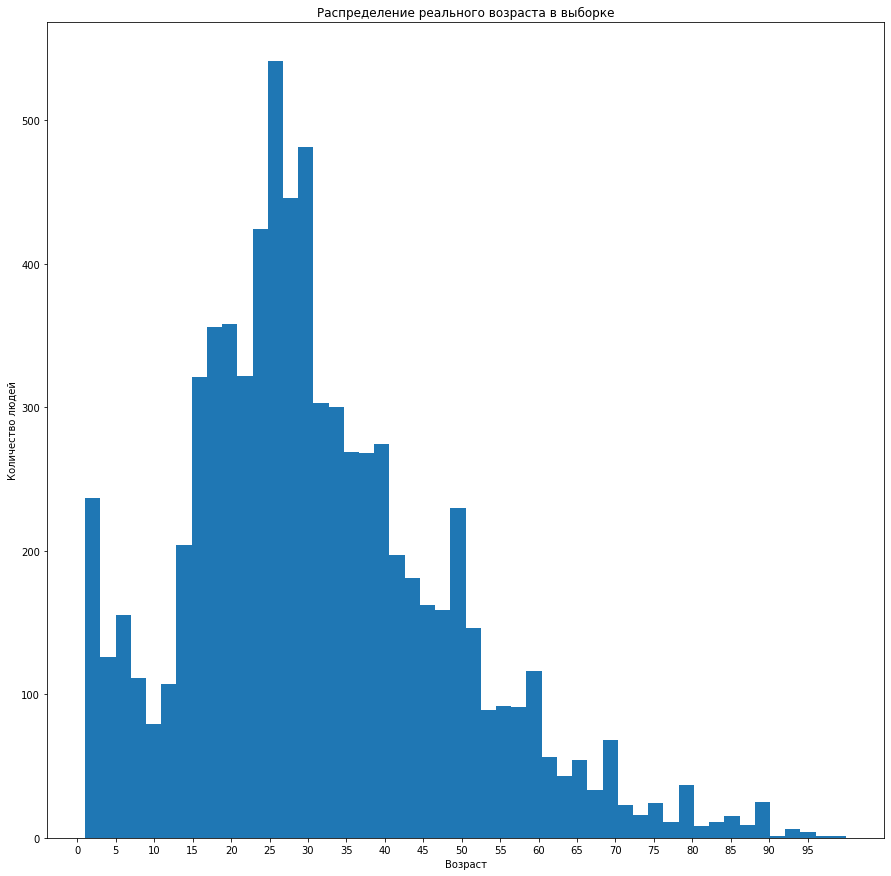

In [6]:
#Посмотрим на гистограмму распределения возраста
plt.figure(figsize=(15, 15))
plt.hist(labels['real_age'], bins=50)
plt.xticks(np.arange(0, 100, step=5))
plt.title("Распределение реального возраста в выборке")
plt.gca().set(xlabel='Возраст', ylabel='Количество людей')

Основную массу людей в выборке составляют люди от 17,5 до 40 лет. Провал по молодёжи объясняем тем, что не все законные представители хоят, чтобы их детей фотографировали, а малое количество пожилых связано с естественными причинами - не зачем учиться очень хорошо распознавать очень пожилых людей, если их активность оставляет желать лучшего (пожилых много, но активных, в экономическом плане, единицы).

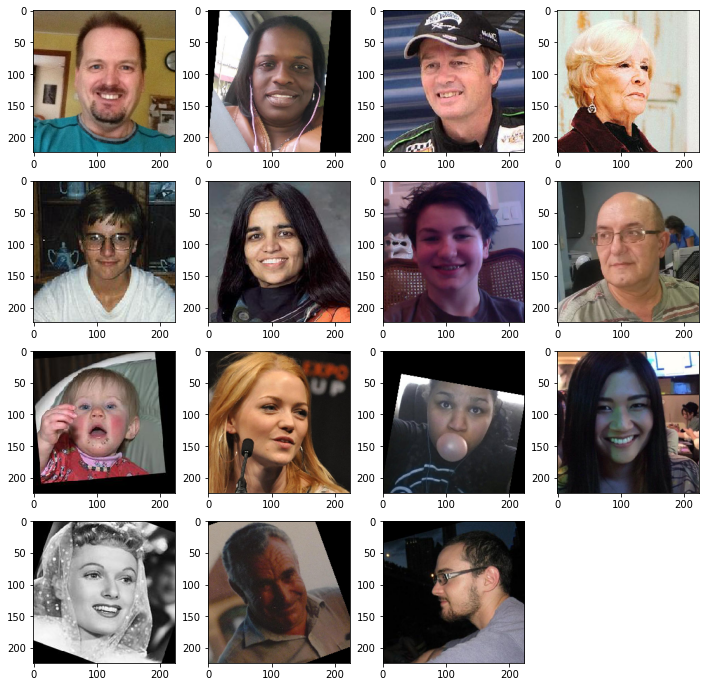

In [7]:
# напечатаем 15 фотографий 
fig = plt.figure(figsize=(12,12))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features_train[i])

По тренировочной выборке можно сказать, что для обучения подобран разнообразный датасет:
* Встречаются фотографии разной цветности
* Фотографии имеют различные смещения (сдвиги, повороты)
* На фотографиях люди разных рас

В совокупности это должно способствовать улучшению предсказаний модели на тестовых данных

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# In[1]:

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

import pandas as pd

# In[2]:
 
def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                     directory=path + 'final_files/', 
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224), 
                                                     batch_size=16, 
                                                     class_mode='raw', 
                                                     subset='training',
                                                     seed=12345)
    return train_datagen_flow

# In[3]:    
 
def load_test(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                     directory=path + 'final_files/', 
                                                     x_col='file_name',
                                                     y_col='real_age', 
                                                     target_size=(224, 224), 
                                                     batch_size=16, 
                                                     class_mode='raw', 
                                                     subset='validation',
                                                     seed=12345)
    return test_datagen_flow

# In[3]:

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, include_top=False)
    optimizer = Adam(lr=0.0001)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu')) 

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# In[4]:
 
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:   
        validation_steps=len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 47s - loss: 208.8731 - mae: 10.4642 - val_loss: 399.2186 - val_mae: 14.9379
Epoch 2/5
356/356 - 38s - loss: 70.0065 - mae: 6.3476 - val_loss: 124.6094 - val_mae: 8.3948
Epoch 3/5
356/356 - 38s - loss: 37.5343 - mae: 4.6823 - val_loss: 93.5693 - val_mae: 7.6681
Epoch 4/5
356/356 - 38s - loss: 24.5335 - mae: 3.8287 - val_loss: 74.7579 - val_mae: 6.7698
Epoch 5/5
356/356 - 38s - loss: 18.6633 - mae: 3.3714 - val_loss: 71.8502 - val_mae: 6.4334

119/119 - 9s - loss: 71.8502 - mae: 6.4334
Test MAE: 6.4334

```

## Анализ обученной модели

Модель побила пороговое MAE менее 7, можем считать обучение успешным. Разберёмся с задачами: 

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы.
    
Данную задачу вполне себе можно решать с помощью данной модели, в маркетинге +- 6,5 лет не будут особенно болезнеными
    
* Контролировать добросовестность кассиров при продаже алкоголя.

Данная тема более деликатная и здесь ошибка может стоить очень дорого. Поэтому для этой задачи использовать данную модель не стоит, либо стоит, но с оговорками: минимальным порогом для контроля следует установить 25 лет, согласно предсказаниям модели. Все граждане, непрошедшие данный ценз, должны будут показывать паспорт, остальным можно продавать и так с минимальными рисками.